In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import surfAnalysisPy as surf
import SUITPy as suit
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.stats as stats
import scipy
import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# 6 by 6 representations

## contra

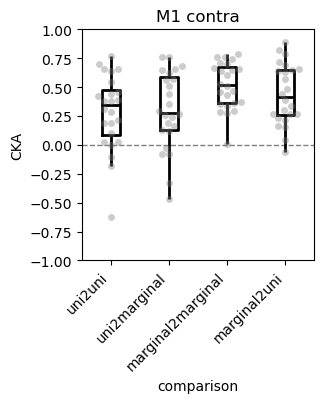

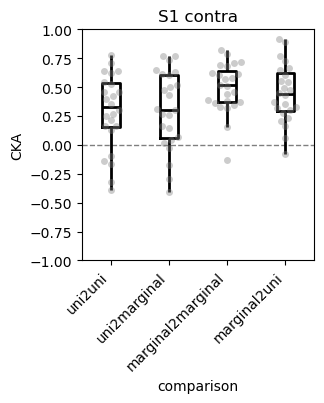

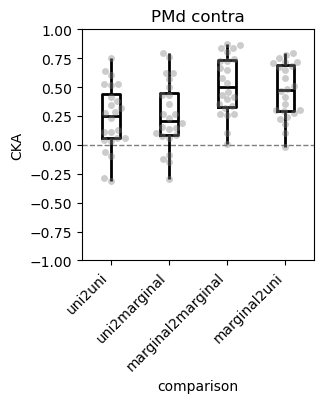

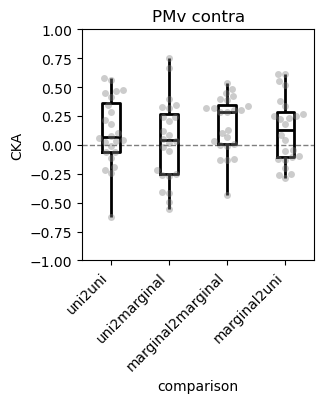

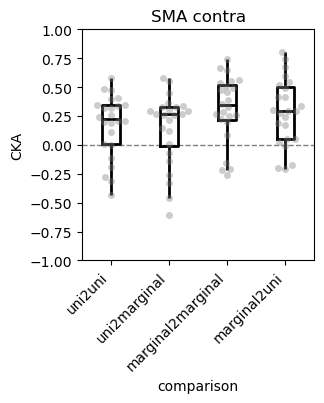

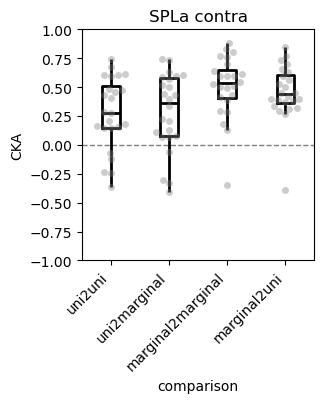

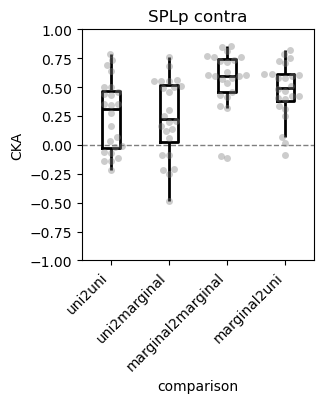

/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


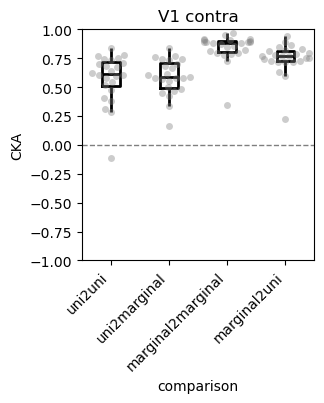

In [37]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

dataset_unimanual_within = pd.read_pickle(os.path.join(analysisDir, 'dataset_unimanual_within.pkl'))
dataset_marginal_within = pd.read_pickle(os.path.join(analysisDir, 'dataset_marginal_within.pkl'))

# --- RDM Calculation ---
for i, region in enumerate(regions):
    subset = dataset_unimanual_within[(dataset_unimanual_within['region'] == f'{region}') & 
                                        (dataset_unimanual_within['type'] == 'contra')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y_uni = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y_uni)
    ncond = len(labels)
    G_uni = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_uni[i_sub, :, :], _ = pcm.est_G_crossval(Y_uni[i_sub].measurements,
                                                    Y_uni[i_sub].obs_descriptors['cond_vec'],
                                                    Y_uni[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y_uni[i_sub].obs_descriptors['part_vec']))

    subset = dataset_marginal_within[(dataset_marginal_within['region'] == f'{region}') & 
                                        (dataset_marginal_within['type'] == 'contra')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y_marginal = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y_marginal)
    ncond = len(labels)
    G_marginal = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_marginal[i_sub, :, :], _ = pcm.est_G_crossval(Y_marginal[i_sub].measurements,
                                                        Y_marginal[i_sub].obs_descriptors['cond_vec'],
                                                        Y_marginal[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y_marginal[i_sub].obs_descriptors['part_vec']))
        
    # leave-one-out CKA:
    r_marginal2marginal, r_marginal2uni, r_uni2uni, r_uni2marginal = [], [], [], []
    for i in range(N):
        # get leave-one-out G:
        G_uni_mean = np.mean(np.delete(G_uni, i, axis=0), axis=0)
        G_uni_loo = G_uni[i, :, :]
        G_marginal_mean = np.mean(np.delete(G_marginal, i, axis=0), axis=0)
        G_marginal_loo = G_marginal[i, :, :]

        # calculate CKA:
        r_uni2uni.append(utils.please.cka(G_uni_loo, G_uni_mean))
        r_uni2marginal.append(utils.please.cka(G_uni_loo, G_marginal_mean))
        r_marginal2marginal.append(utils.please.cka(G_marginal_loo, G_marginal_mean))
        r_marginal2uni.append(utils.please.cka(G_marginal_loo, G_uni_mean))
    
    # boxplot for region:
    data = [r_uni2uni, r_uni2marginal, r_marginal2marginal, r_marginal2uni]
    labels_box = ['uni2uni', 'uni2marginal', 'marginal2marginal', 'marginal2uni']
    df = pd.DataFrame({ 'cka': np.concatenate(data),
                        'comparison': np.repeat(labels_box, repeats=N)})
    plt.figure(figsize=(3,3))
    sns.swarmplot(x='comparison', y='cka', data=df, color=".5", alpha=0.4)
    sns.boxplot(x='comparison', y='cka', data=df, fill=False, color='k', linewidth=2, width=0.3, showfliers=False, showcaps=False)
    plt.title(f'{region} contra')
    plt.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
    plt.ylim(-1,1)
    plt.ylabel('CKA')
    plt.xticks(rotation=45, ha='right')
    plt.show()




## ipsilateral

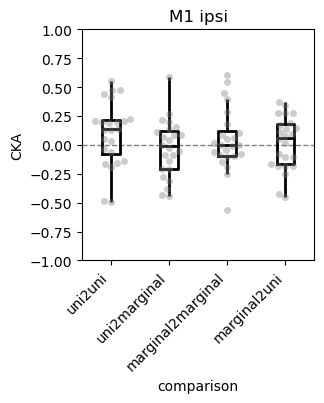

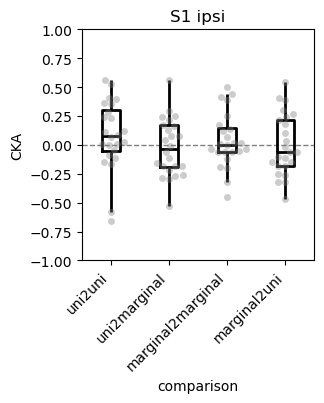

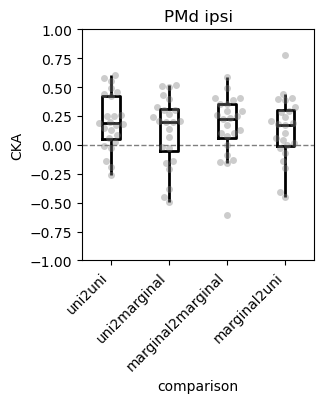

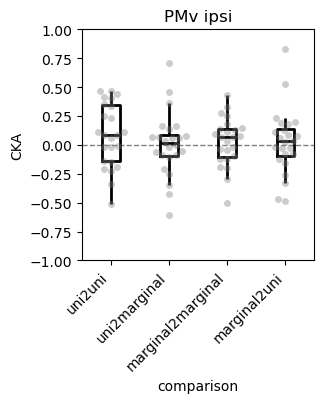

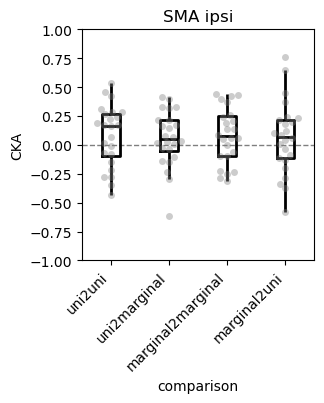

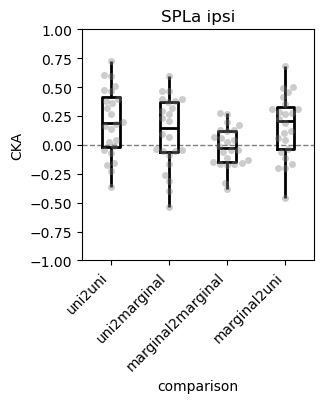

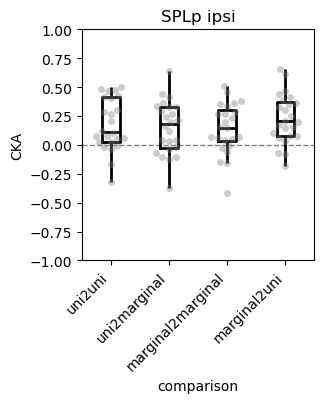

/Users/aghavamp/Desktop/Projects/bimanual_wrist/.conda/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


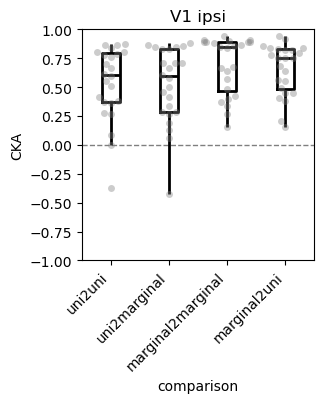

In [39]:
regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

dataset_unimanual_within = pd.read_pickle(os.path.join(analysisDir, 'dataset_unimanual_within.pkl'))
dataset_marginal_within = pd.read_pickle(os.path.join(analysisDir, 'dataset_marginal_within.pkl'))

# --- RDM Calculation ---
for i, region in enumerate(regions):
    subset = dataset_unimanual_within[(dataset_unimanual_within['region'] == f'{region}') & 
                                        (dataset_unimanual_within['type'] == 'ipsi')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y_uni = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y_uni)
    ncond = len(labels)
    G_uni = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_uni[i_sub, :, :], _ = pcm.est_G_crossval(Y_uni[i_sub].measurements,
                                                    Y_uni[i_sub].obs_descriptors['cond_vec'],
                                                    Y_uni[i_sub].obs_descriptors['part_vec'],
                                                    X=pcm.matrix.indicator(Y_uni[i_sub].obs_descriptors['part_vec']))

    subset = dataset_marginal_within[(dataset_marginal_within['region'] == f'{region}') & 
                                        (dataset_marginal_within['type'] == 'ipsi')]
    Y1 = subset['Y'].iloc[0]
    Y2 = subset['Y'].iloc[1]
    Y_marginal = Y1 + Y2  # concatenate the two lists of datasets
    labels = subset['labels'].iloc[0]
    N = len(Y_marginal)
    ncond = len(labels)
    G_marginal = np.zeros((N, ncond, ncond))
    for i_sub in range(N):
        G_marginal[i_sub, :, :], _ = pcm.est_G_crossval(Y_marginal[i_sub].measurements,
                                                        Y_marginal[i_sub].obs_descriptors['cond_vec'],
                                                        Y_marginal[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y_marginal[i_sub].obs_descriptors['part_vec']))
        
    # leave-one-out CKA:
    r_marginal2marginal, r_marginal2uni, r_uni2uni, r_uni2marginal = [], [], [], []
    for i in range(N):
        # get leave-one-out G:
        G_uni_mean = np.mean(np.delete(G_uni, i, axis=0), axis=0)
        G_uni_loo = G_uni[i, :, :]
        G_marginal_mean = np.mean(np.delete(G_marginal, i, axis=0), axis=0)
        G_marginal_loo = G_marginal[i, :, :]

        # calculate CKA:
        r_uni2uni.append(utils.please.cka(G_uni_loo, G_uni_mean))
        r_uni2marginal.append(utils.please.cka(G_uni_loo, G_marginal_mean))
        r_marginal2marginal.append(utils.please.cka(G_marginal_loo, G_marginal_mean))
        r_marginal2uni.append(utils.please.cka(G_marginal_loo, G_uni_mean))
    
    # boxplot for region:
    data = [r_uni2uni, r_uni2marginal, r_marginal2marginal, r_marginal2uni]
    labels_box = ['uni2uni', 'uni2marginal', 'marginal2marginal', 'marginal2uni']
    df = pd.DataFrame({ 'cka': np.concatenate(data),
                        'comparison': np.repeat(labels_box, repeats=N)})
    plt.figure(figsize=(3,3))
    sns.swarmplot(x='comparison', y='cka', data=df, color=".5", alpha=0.4)
    sns.boxplot(x='comparison', y='cka', data=df, fill=False, color='k', linewidth=2, width=0.3, showfliers=False, showcaps=False)
    plt.title(f'{region} ipsi')
    plt.axhline(0, color='k', linestyle='--', linewidth=1, alpha=0.5)
    plt.ylim(-1,1)
    plt.ylabel('CKA')
    plt.xticks(rotation=45, ha='right')
    plt.show()




# 12 by 12 marginal representations

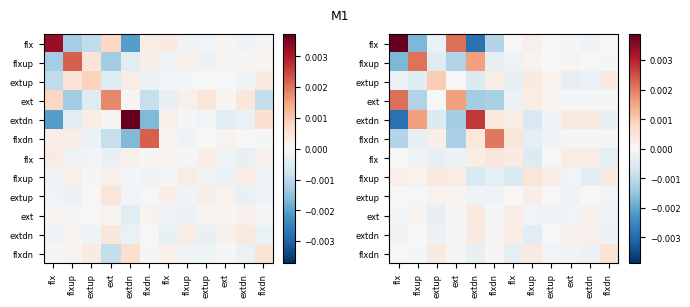

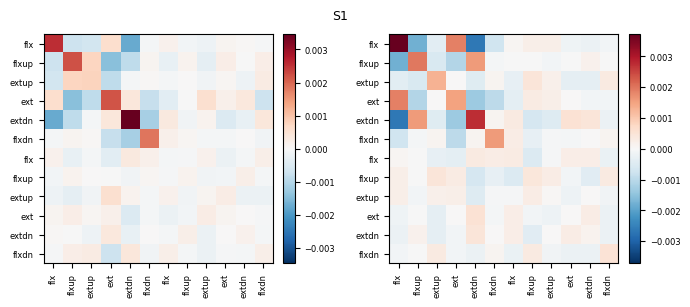

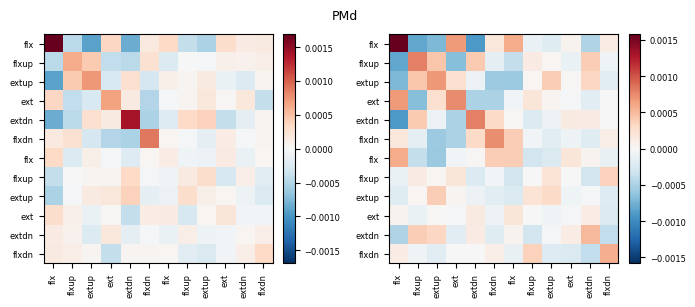

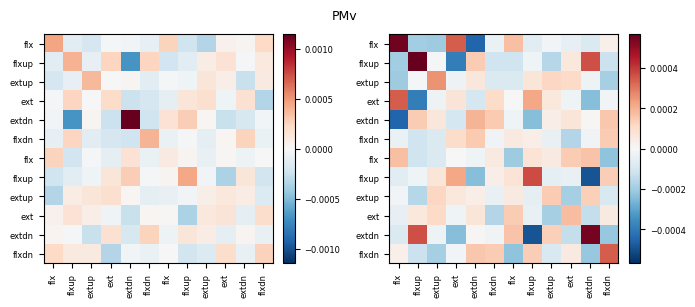

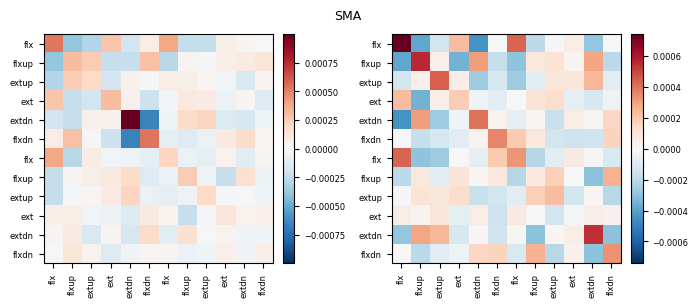

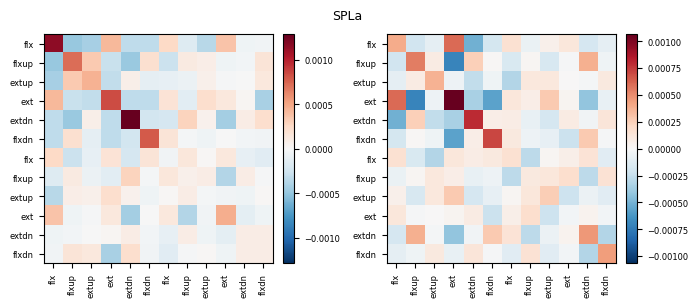

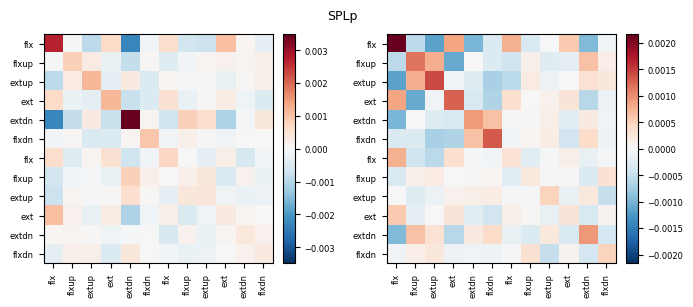

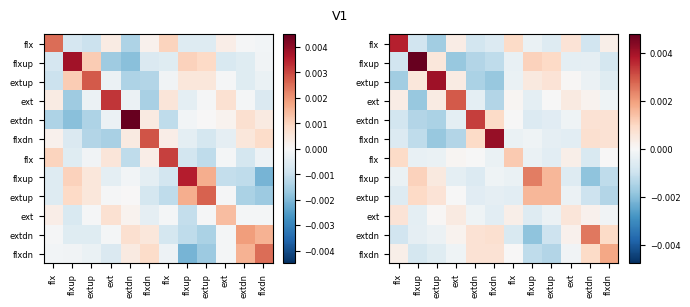

In [9]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r'
sn_bad = [102, 103]

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'M1'

RDMs_marginal = {'sn': [], 'region':[], 'hem':[], 'labels': [], 'G': [], 'D^2': []}

hem = ['L', 'R']
for region in regions:
    for i_hem, h in enumerate(hem):
        data, cond_vec, part_vec = [], [], []
        roi = f'{region}_{h}'
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            Y = []
            subj_part = []
            subj_cond = []

            # lhand marginal:
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that left hand goes in that direction:
                    tmp_name = f'bi:{direction}_'
                    idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'lhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            # rhand marginal:
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that right hand goes in that direction:
                    tmp_name = f'_{direction}'
                    idx1 = np.array([tmp.endswith(tmp_name) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'rhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            subj_cond = np.array(subj_cond)
            # Sort based on Hemisphere to have contralateral first:
            if h == 'L':
                tmp = subj_cond.copy()
                subj_cond[tmp > 5] = tmp[tmp > 5] - 6
                subj_cond[tmp <= 5] = tmp[tmp <= 5] + 6 

            data.append(Y)
            cond_vec.append(subj_cond)
            part_vec.append(subj_part)

        Y = []
        labels = ['flx','flxup','extup','ext','extdn','flxdn']*2
        # --- RDM Calculation ---
        for i_sub in range(len(data)):
            obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
            Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

        N = len(Y)
        ncond = 12
        G_hat = np.zeros((N, ncond, ncond))
        for i_sub in range(N):
            G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                        Y[i_sub].obs_descriptors['cond_vec'],
                                                        Y[i_sub].obs_descriptors['part_vec'],
                                                        X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))
            RDMs_marginal['sn'].append(subject[i_sub])
            RDMs_marginal['region'].append(region)
            RDMs_marginal['hem'].append(h)
            RDMs_marginal['labels'].append(labels)
            RDMs_marginal['G'].append(G_hat[i_sub, :, :])
            dist = pcm.G_to_dist(G_hat[i_sub, :, :])
            RDMs_marginal['D^2'].append(dist)


RDMs_marginal = pd.DataFrame(RDMs_marginal)
RDMs_marginal.to_pickle(os.path.join(analysisDir, 'RDMs_marginal.pkl'))


# PLOT:
plt.rcParams.update({'font.size': 6})
cmap = 'RdBu_r'
for region in regions:
    tmp = RDMs_marginal[(RDMs_marginal['region']==region) & (RDMs_marginal['hem']=='L')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_L = np.mean(D, axis=0)
    G = tmp['G'].to_list()
    G = np.array(G)
    G_avg_L = np.mean(G, axis=0)

    tmp = RDMs_marginal[(RDMs_marginal['region']==region) & (RDMs_marginal['hem']=='R')]
    D = tmp['D^2'].to_list()
    D = np.array(D)
    D = np.sign(D) * np.sqrt(np.abs(D))
    D_avg_R = np.mean(D, axis=0)
    G = tmp['G'].to_list()
    G = np.array(G)
    G_avg_R = np.mean(G, axis=0)

    fig, ax = plt.subplots(1,2, figsize=(7,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, d in enumerate([G_avg_L, G_avg_R]):
        plt.sca(ax[i])
        vmin = -np.max(np.abs(d))
        vmax = np.max(np.abs(d))
        im = ax[i].imshow(d, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.colorbar(im, fraction=0.046, pad=0.04)
        ax[i].set_xticks(np.arange(len(labels)))
        ax[i].set_yticks(np.arange(len(labels)))
        ax[i].set_xticklabels(labels)
        ax[i].set_yticklabels(labels)
        ax[i].set_xticks(list(range(len(labels))))
        ax[i].set_xticklabels(labels, rotation=90)
        ax[i].set_yticks(list(range(len(labels))))
        ax[i].set_yticklabels(labels)
    plt.tight_layout()
    plt.show()





## Similarity between Within-Contra and Within-Ipsi 

M1 L full average contra-ipsi correlation: r = 0.51
M1 R full average contra-ipsi correlation: r = 0.25
S1 L full average contra-ipsi correlation: r = 0.10
S1 R full average contra-ipsi correlation: r = 0.21
PMd L full average contra-ipsi correlation: r = 0.48
PMd R full average contra-ipsi correlation: r = 0.44
PMv L full average contra-ipsi correlation: r = 0.03
PMv R full average contra-ipsi correlation: r = 0.03
SMA L full average contra-ipsi correlation: r = 0.34
SMA R full average contra-ipsi correlation: r = 0.33
SPLa L full average contra-ipsi correlation: r = 0.39
SPLa R full average contra-ipsi correlation: r = 0.21
SPLp L full average contra-ipsi correlation: r = 0.71
SPLp R full average contra-ipsi correlation: r = 0.46
V1 L full average contra-ipsi correlation: r = 0.87
V1 R full average contra-ipsi correlation: r = 0.85
M1 L2L:
    contra-contra: t=9.77, p=0.0000
    contra-ipsi: t=5.26, p=0.0003
    ipsi-ipsi: t=0.24, p=0.8163
    ipsi-contra: t=3.55, p=0.0046
M1 L2R:
  

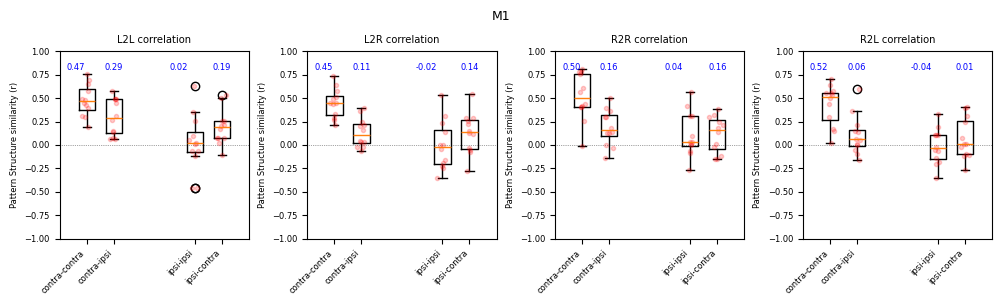

S1 L2L:
    contra-contra: t=10.76, p=0.0000
    contra-ipsi: t=1.47, p=0.1699
    ipsi-ipsi: t=-0.16, p=0.8788
    ipsi-contra: t=-0.11, p=0.9146
S1 L2R:
    contra-contra: t=9.47, p=0.0000
    contra-ipsi: t=3.35, p=0.0065
    ipsi-ipsi: t=-0.51, p=0.6224
    ipsi-contra: t=0.01, p=0.9956
S1 R2R:
    contra-contra: t=5.87, p=0.0001
    contra-ipsi: t=2.52, p=0.0285
    ipsi-ipsi: t=2.45, p=0.0320
    ipsi-contra: t=2.39, p=0.0360
S1 R2L:
    contra-contra: t=5.90, p=0.0001
    contra-ipsi: t=-0.04, p=0.9711
    ipsi-ipsi: t=-0.29, p=0.7797
    ipsi-contra: t=1.75, p=0.1075


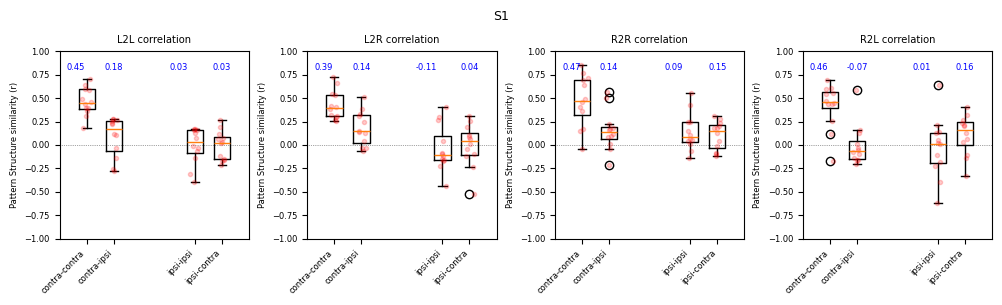

PMd L2L:
    contra-contra: t=9.35, p=0.0000
    contra-ipsi: t=5.76, p=0.0001
    ipsi-ipsi: t=0.58, p=0.5742
    ipsi-contra: t=1.43, p=0.1812
PMd L2R:
    contra-contra: t=7.56, p=0.0000
    contra-ipsi: t=12.96, p=0.0000
    ipsi-ipsi: t=0.79, p=0.4438
    ipsi-contra: t=1.77, p=0.1039
PMd R2R:
    contra-contra: t=6.99, p=0.0000
    contra-ipsi: t=2.95, p=0.0131
    ipsi-ipsi: t=5.24, p=0.0003
    ipsi-contra: t=3.04, p=0.0113
PMd R2L:
    contra-contra: t=4.95, p=0.0004
    contra-ipsi: t=5.03, p=0.0004
    ipsi-ipsi: t=2.10, p=0.0592
    ipsi-contra: t=3.63, p=0.0040


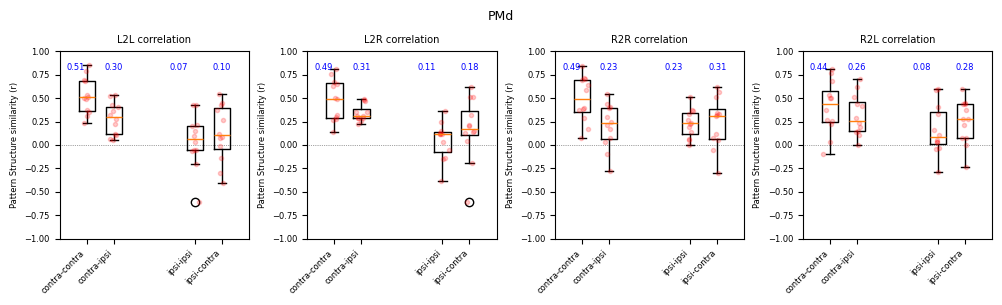

PMv L2L:
    contra-contra: t=3.36, p=0.0063
    contra-ipsi: t=0.36, p=0.7248
    ipsi-ipsi: t=0.42, p=0.6832
    ipsi-contra: t=0.36, p=0.7227
PMv L2R:
    contra-contra: t=1.05, p=0.3153
    contra-ipsi: t=0.95, p=0.3638
    ipsi-ipsi: t=0.56, p=0.5843
    ipsi-contra: t=0.86, p=0.4056
PMv R2R:
    contra-contra: t=1.89, p=0.0856
    contra-ipsi: t=-0.06, p=0.9529
    ipsi-ipsi: t=0.21, p=0.8386
    ipsi-contra: t=0.70, p=0.4998
PMv R2L:
    contra-contra: t=0.77, p=0.4552
    contra-ipsi: t=1.77, p=0.1038
    ipsi-ipsi: t=0.76, p=0.4634
    ipsi-contra: t=1.31, p=0.2178


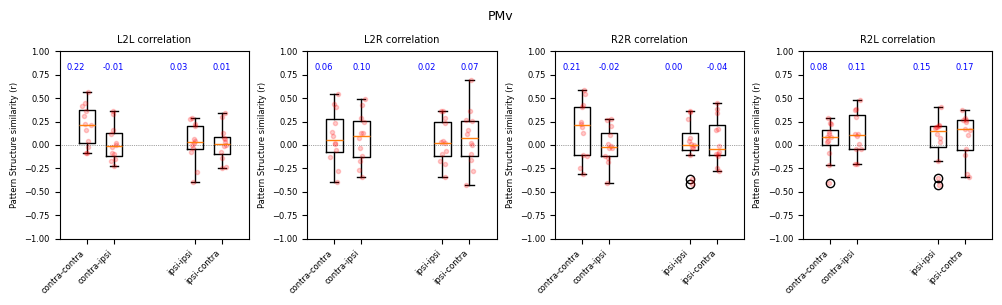

SMA L2L:
    contra-contra: t=7.31, p=0.0000
    contra-ipsi: t=2.55, p=0.0269
    ipsi-ipsi: t=-0.49, p=0.6343
    ipsi-contra: t=0.02, p=0.9856
SMA L2R:
    contra-contra: t=6.31, p=0.0001
    contra-ipsi: t=7.07, p=0.0000
    ipsi-ipsi: t=-0.20, p=0.8421
    ipsi-contra: t=0.19, p=0.8509
SMA R2R:
    contra-contra: t=2.65, p=0.0224
    contra-ipsi: t=0.66, p=0.5231
    ipsi-ipsi: t=4.14, p=0.0017
    ipsi-contra: t=2.08, p=0.0620
SMA R2L:
    contra-contra: t=1.76, p=0.1061
    contra-ipsi: t=2.25, p=0.0461
    ipsi-ipsi: t=0.67, p=0.5195
    ipsi-contra: t=4.40, p=0.0011


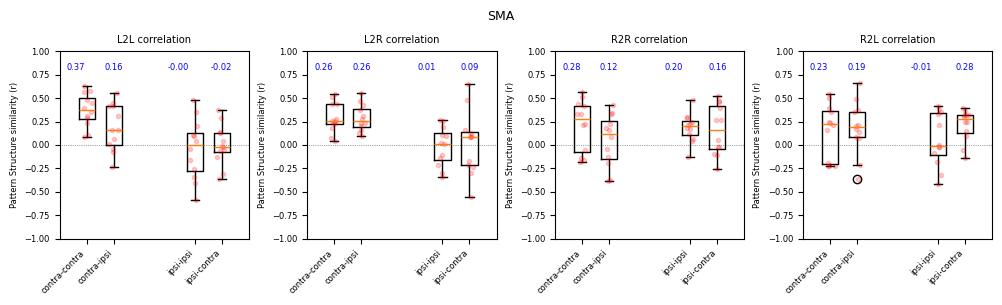

SPLa L2L:
    contra-contra: t=9.91, p=0.0000
    contra-ipsi: t=4.38, p=0.0011
    ipsi-ipsi: t=0.93, p=0.3747
    ipsi-contra: t=2.35, p=0.0387
SPLa L2R:
    contra-contra: t=8.45, p=0.0000
    contra-ipsi: t=4.02, p=0.0020
    ipsi-ipsi: t=-1.54, p=0.1511
    ipsi-contra: t=2.91, p=0.0142
SPLa R2R:
    contra-contra: t=5.12, p=0.0003
    contra-ipsi: t=1.04, p=0.3226
    ipsi-ipsi: t=0.85, p=0.4125
    ipsi-contra: t=1.11, p=0.2911
SPLa R2L:
    contra-contra: t=4.25, p=0.0014
    contra-ipsi: t=4.07, p=0.0018
    ipsi-ipsi: t=-1.40, p=0.1890
    ipsi-contra: t=1.94, p=0.0788


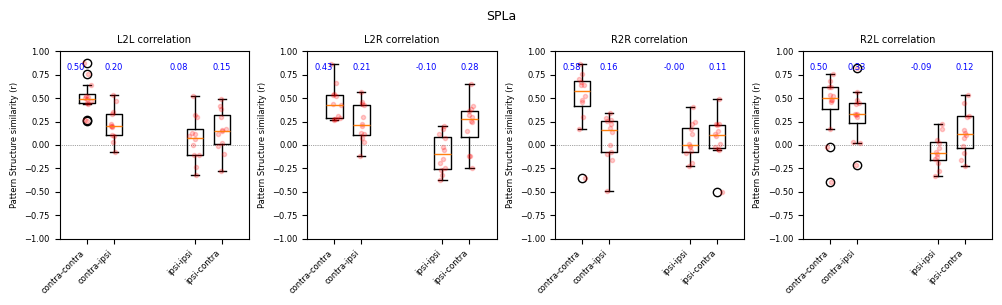

SPLp L2L:
    contra-contra: t=10.07, p=0.0000
    contra-ipsi: t=10.18, p=0.0000
    ipsi-ipsi: t=2.24, p=0.0469
    ipsi-contra: t=2.66, p=0.0223
SPLp L2R:
    contra-contra: t=9.82, p=0.0000
    contra-ipsi: t=7.11, p=0.0000
    ipsi-ipsi: t=0.21, p=0.8366
    ipsi-contra: t=3.82, p=0.0028
SPLp R2R:
    contra-contra: t=6.80, p=0.0000
    contra-ipsi: t=2.25, p=0.0455
    ipsi-ipsi: t=1.14, p=0.2772
    ipsi-contra: t=4.73, p=0.0006
SPLp R2L:
    contra-contra: t=4.47, p=0.0009
    contra-ipsi: t=5.30, p=0.0003
    ipsi-ipsi: t=2.36, p=0.0375
    ipsi-contra: t=3.66, p=0.0038


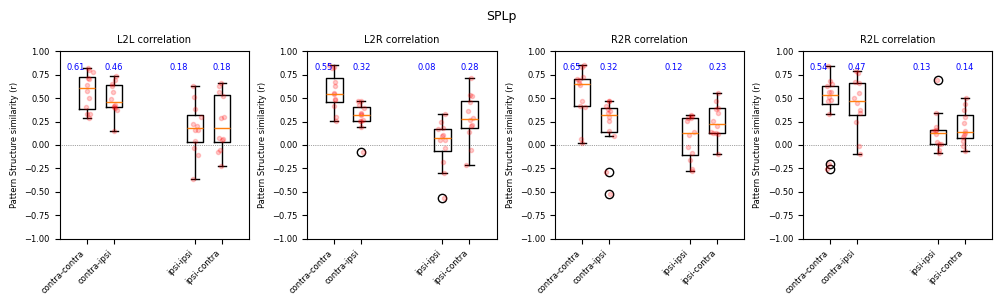

V1 L2L:
    contra-contra: t=19.05, p=0.0000
    contra-ipsi: t=13.36, p=0.0000
    ipsi-ipsi: t=9.37, p=0.0000
    ipsi-contra: t=13.26, p=0.0000
V1 L2R:
    contra-contra: t=16.45, p=0.0000
    contra-ipsi: t=13.78, p=0.0000
    ipsi-ipsi: t=10.42, p=0.0000
    ipsi-contra: t=11.32, p=0.0000
V1 R2R:
    contra-contra: t=48.12, p=0.0000
    contra-ipsi: t=28.50, p=0.0000
    ipsi-ipsi: t=8.14, p=0.0000
    ipsi-contra: t=10.04, p=0.0000
V1 R2L:
    contra-contra: t=42.00, p=0.0000
    contra-ipsi: t=32.65, p=0.0000
    ipsi-ipsi: t=9.37, p=0.0000
    ipsi-contra: t=10.35, p=0.0000


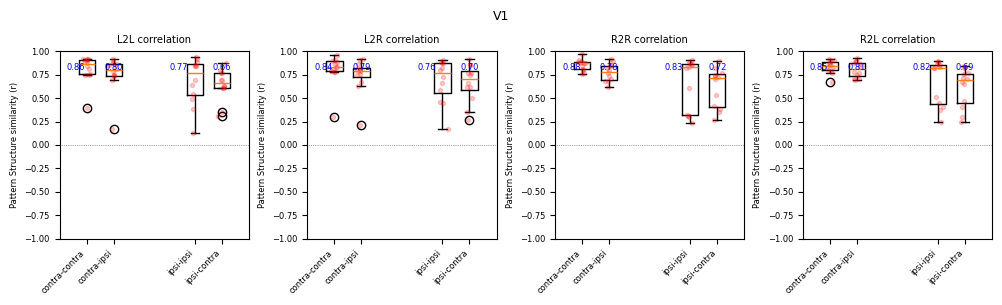

In [10]:
def cka(G1, G2):
    '''
    Compute the Centered Kernel Alignment (CKA) between two kernel (similarity) matrices G1 and G2.
    '''
    # Center the matrices
    n = G1.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    G1_centered = H @ G1 @ H
    G2_centered = H @ G2 @ H

    # Compute the CKA
    cka = np.sum(G1_centered * G2_centered) / (np.sqrt(np.sum(G1_centered ** 2)) * np.sqrt(np.sum(G2_centered ** 2)))
    return cka

df = {'region': [], 'hem': [], 'within_hem': [], 'sn': [], 'r_contra_contra': [], 'r_ipsi_ipsi': [], 'r_contra_ipsi': [], 'r_ipsi_contra': []}

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L', 'R']
for region in regions:
    # ============================= Within Hem =============================
    for i, h in enumerate(hem):
        tmp = RDMs_marginal[(RDMs_marginal['region']==region) & (RDMs_marginal['hem']==h)]
        G = tmp['G'].to_list()
        G = np.array(G)
        # N-1 cross validation:
        N = np.shape(G)[0]
        r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
        for i in range(N):
            G_mean = np.mean(np.delete(G, i, axis=0), axis=0)
            # G_mean = pcm.G_to_dist(G_mean)
            G_sub = G[i, :, :]
            # G_sub = pcm.G_to_dist(G_sub)

            # imshow of G_mean and G_sub with subplots(1,2):
            # if region == 'M1':
            #     cmap = 'RdBu_r'
            #     fig, ax = plt.subplots(1,2, figsize=(3.5,2))
            #     vmin = -np.max(np.abs(G_sub))
            #     vmax = np.max(np.abs(G_sub))
            #     ax[0].imshow(G_sub, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[0].set_title('G_sub')
            #     vmin = -np.max(np.abs(G_mean))
            #     vmax = np.max(np.abs(G_mean))
            #     ax[1].imshow(G_mean, cmap=cmap, vmin=vmin, vmax=vmax)
            #     ax[1].set_title('G_mean')
            #     plt.suptitle(f'sn {tmp["sn"].values[i]} - {region}_{h}', fontsize=9)
            #     plt.tight_layout()
            #     plt.show()

            # contra-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[:6, :6]
            r = cka(G1, G2)
            r_contra_contra.append(r)

            # ipsi-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[6:, 6:]
            r = cka(G1, G2)
            r_ipsi_ipsi.append(r)

            # contra-ipsi:
            G1 = G_mean[6:, 6:]
            G2 = G_sub[:6, :6]
            r = cka(G1, G2)
            r_contra_ipsi.append(r)

            # ipsi-contra:
            G1 = G_mean[:6, :6]
            G2 = G_sub[6:, 6:]
            r = cka(G1, G2)
            r_ipsi_contra.append(r)

        df['region'].append(region)
        df['hem'].append(f'{h}2{h}')
        df['within_hem'].append('within')
        df['sn'].append(list(tmp['sn']))
        df['r_contra_contra'].append(r_contra_contra)
        df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
        df['r_contra_ipsi'].append(r_contra_ipsi)
        df['r_ipsi_contra'].append(r_ipsi_contra)

        # also estimate full average corrleation:
        G_mean = np.mean(G, axis=0)
        G1 = G_mean[:6, :6] # contra
        G2 = G_mean[6:, 6:] # ipsi
        r = cka(G1, G2)
        print(f'{region} {h} full average contra-ipsi correlation: r = {r:.2f}')
    
    # Between Hemisphere Correlation:
    tmp = RDMs_marginal[(RDMs_marginal['region']==region) & (RDMs_marginal['hem']=='L')]
    G_L = tmp['G'].to_list()
    G_L = np.array(G_L)

    tmp = RDMs_marginal[(RDMs_marginal['region']==region) & (RDMs_marginal['hem']=='R')]
    G_R = tmp['G'].to_list()
    G_R = np.array(G_R)

    # ============================= L to R =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_R = np.mean(np.delete(G_R, i, axis=0), axis=0)
        # G_mean_R = pcm.G_to_dist(G_mean_R)
        G_sub_L = G_L[i, :, :]
        # G_sub_L = pcm.G_to_dist(G_sub_L)

        # contra-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[:6, :6]
        r = cka(G1, G2)
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_R[6:, 6:]
        G2 = G_sub_L[:6, :6]
        r = cka(G1, G2)
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_R[:6, :6]
        G2 = G_sub_L[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('L2R')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)

    # ============================= R to L =============================
    # N-1 cross validation:
    N = np.shape(G_L)[0]
    r_contra_contra, r_ipsi_ipsi, r_contra_ipsi, r_ipsi_contra = [], [], [], []
    for i in range(N):
        G_mean_L = np.mean(np.delete(G_L, i, axis=0), axis=0)
        # G_mean_L = pcm.G_to_dist(G_mean_L)
        G_sub_R = G_R[i, :, :]
        # G_sub_R = pcm.G_to_dist(G_sub_R)

        # contra-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[:6, :6]
        r = cka(G1, G2)
        r_contra_contra.append(r)

        # ipsi-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_ipsi.append(r)

        # contra-ipsi:
        G1 = G_mean_L[6:, 6:]
        G2 = G_sub_R[:6, :6]
        r = cka(G1, G2)
        r_contra_ipsi.append(r)

        # ipsi-contra:
        G1 = G_mean_L[:6, :6]
        G2 = G_sub_R[6:, 6:]
        r = cka(G1, G2)
        r_ipsi_contra.append(r)
    df['region'].append(region)
    df['hem'].append('R2L')
    df['within_hem'].append('between')
    df['sn'].append(list(tmp['sn']))
    df['r_contra_contra'].append(r_contra_contra)
    df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
    df['r_contra_ipsi'].append(r_contra_ipsi)
    df['r_ipsi_contra'].append(r_ipsi_contra)
df = pd.DataFrame(df)

# PLOT:
# In one box plot:
# First within hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
# Then between hemisphere boxplot, contra-contra, contra-ipsi, ipsi-ipsi, ipsi-contra
plt.rcParams.update({'font.size': 6})
for region in regions:
    fig, ax = plt.subplots(1,4, figsize=(10,3))
    name = f'{region}'
    # main title:
    plt.suptitle(f'{name}', fontsize=9)
    for i, wh in enumerate(['L2L', 'L2R', 'R2R', 'R2L']):
        plt.sca(ax[i])
        tmp = df[(df['region']==region) & (df['hem']==wh)]
        r_contra_contra = tmp['r_contra_contra'].values[0]
        r_ipsi_ipsi = tmp['r_ipsi_ipsi'].values[0]
        r_contra_ipsi = tmp['r_contra_ipsi'].values[0]
        r_ipsi_contra = tmp['r_ipsi_contra'].values[0]
        data_plot = [r_contra_contra, r_contra_ipsi, r_ipsi_ipsi, r_ipsi_contra]
        ax[i].boxplot(data_plot, positions=[1,1.5,3,3.5], widths=0.3)
        ax[i].axhline(0, color='k', linestyle=':', linewidth=0.5, alpha=0.7)
        ax[i].set_xticks([1,1.5,3,3.5])
        ax[i].set_xticklabels(['contra-contra', 'contra-ipsi', 'ipsi-ipsi', 'ipsi-contra'], rotation=45, ha='right')
        ax[i].set_ylabel('Pattern Structure similarity (r)')
        ax[i].set_ylim([-1, 1])
        ax[i].set_title(f'{wh} correlation')
        # ax[i].set_yticks(np.arange(-0.1, 1.1, 0.2))

        # individual data points:
        for j in range(len(data_plot)):
            y = data_plot[j]
            x = np.random.normal([1,1.5,3,3.5][j], 0.04, size=len(y))  # add some random "jitter" to the x-axis
            ax[i].plot(x, y, 'r.', alpha=0.2)

        # print mean values:
        for j in range(len(data_plot)):
            y = data_plot[j]
            median_val = np.median(y)
            ax[i].text([0.8,1.5,2.7,3.5][j], 0.8, f'{median_val:.2f}', ha='center', fontsize=6, color='blue')
        
        # test vs 0 for each box:
        print(f'{region} {wh}:')
        for j in range(len(data_plot)):
            y = data_plot[j]
            t, p = scipy.stats.ttest_1samp(y, 0)
            print(f'    {["contra-contra", "contra-ipsi", "ipsi-ipsi", "ipsi-contra"][j]}: t={t:.2f}, p={p:.4f}')
    plt.tight_layout()
    plt.show()



## Marginal and Unimanual similarity

M1:
    contra-contra: t=8.07, p=0.0000
    contra-ipsi: t=5.43, p=0.0000
    ipsi-ipsi: t=0.74, p=0.4657
    ipsi-contra: t=2.33, p=0.0288
S1:
    contra-contra: t=8.64, p=0.0000
    contra-ipsi: t=3.89, p=0.0007
    ipsi-ipsi: t=0.39, p=0.7028
    ipsi-contra: t=0.88, p=0.3896
PMd:
    contra-contra: t=9.27, p=0.0000
    contra-ipsi: t=7.99, p=0.0000
    ipsi-ipsi: t=2.31, p=0.0304
    ipsi-contra: t=2.45, p=0.0221
PMv:
    contra-contra: t=2.34, p=0.0285
    contra-ipsi: t=2.35, p=0.0275
    ipsi-ipsi: t=0.66, p=0.5130
    ipsi-contra: t=1.05, p=0.3042
SMA:
    contra-contra: t=4.84, p=0.0001
    contra-ipsi: t=4.54, p=0.0001
    ipsi-ipsi: t=1.12, p=0.2743
    ipsi-contra: t=1.42, p=0.1702
SPLa:
    contra-contra: t=8.76, p=0.0000
    contra-ipsi: t=8.73, p=0.0000
    ipsi-ipsi: t=3.02, p=0.0061
    ipsi-contra: t=3.34, p=0.0028
SPLp:
    contra-contra: t=9.75, p=0.0000
    contra-ipsi: t=11.16, p=0.0000
    ipsi-ipsi: t=5.32, p=0.0000
    ipsi-contra: t=4.12, p=0.0004
V1:
    cont

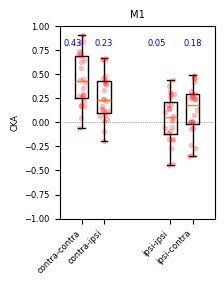

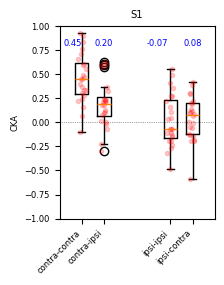

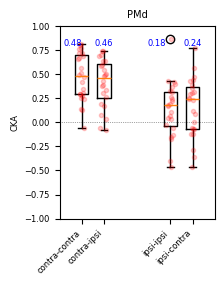

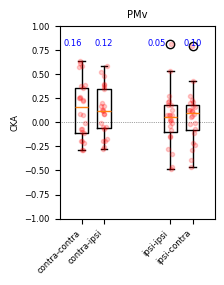

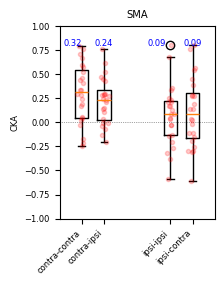

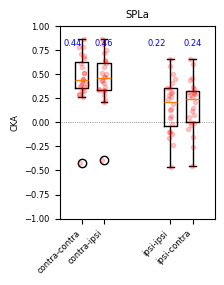

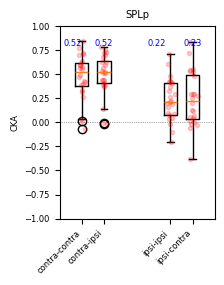

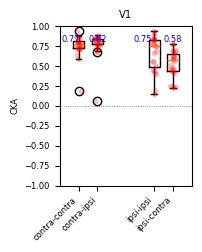

In [ ]:
def cka(G1, G2):
    '''
    Compute the Centered Kernel Alignment (CKA) between two kernel (similarity) matrices G1 and G2.
    '''
    # Center the matrices
    n = G1.shape[0]
    H = np.eye(n) - np.ones((n, n)) / n
    G1_centered = H @ G1 @ H
    G2_centered = H @ G2 @ H

    # Compute the CKA
    cka = np.sum(G1_centered * G2_centered) / (np.sqrt(np.sum(G1_centered ** 2)) * np.sqrt(np.sum(G2_centered ** 2)))
    return cka

RDMs_unimanual = pd.read_pickle(os.path.join(analysisDir, 'RDMs_unimanual.pkl'))

df = {'region': [], 'sn': [], 'r_contra_contra': [], 'r_ipsi_ipsi': [], 'r_contra_ipsi': [], 'r_ipsi_contra': []}

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
hem = ['L', 'R']
for region in regions:
    G_unimanual = RDMs_unimanual[RDMs_unimanual['region']==region]['G'].to_list()
    G_unimanual = np.array(G_unimanual)
    G_unimanual = np.mean(G_unimanual, axis=0)
    G_unimanual_contra = G_unimanual[:6, :6]
    G_unimanual_ipsi = G_unimanual[6:, 6:]

    G_marginal = RDMs_marginal[RDMs_marginal['region']==region]['G'].to_list()
    G_marginal = np.array(G_marginal)

    N = np.shape(G_marginal)[0]
    for i in range(N):
        G_sub = G_marginal[i, :, :]
        G_sub_contra = G_sub[:6, :6]
        G_sub_ipsi = G_sub[6:, 6:]

        r_contra_contra = cka(G_unimanual_contra, G_sub_contra)
        r_ipsi_ipsi = cka(G_unimanual_ipsi, G_sub_ipsi)
        r_ipsi_contra = cka(G_unimanual_contra, G_sub_ipsi)
        r_contra_ipsi = cka(G_unimanual_ipsi, G_sub_contra)

        df['region'].append(region)
        df['sn'].append(i)
        df['r_contra_contra'].append(r_contra_contra)
        df['r_ipsi_ipsi'].append(r_ipsi_ipsi)
        df['r_contra_ipsi'].append(r_contra_ipsi)
        df['r_ipsi_contra'].append(r_ipsi_contra)
df = pd.DataFrame(df)

# PLOT:
plt.rcParams.update({'font.size': 6})
for region in regions:
    fig, ax = plt.subplots(1, figsize=(2,2.5))
    tmp = df[(df['region']==region)]
    r_contra_contra = tmp['r_contra_contra'].values
    r_ipsi_ipsi = tmp['r_ipsi_ipsi'].values
    r_contra_ipsi = tmp['r_contra_ipsi'].values
    r_ipsi_contra = tmp['r_ipsi_contra'].values
    data_plot = [r_contra_contra, r_contra_ipsi, r_ipsi_ipsi, r_ipsi_contra]
    ax.boxplot(data_plot, positions=[1,1.5,3,3.5], widths=0.3)
    ax.axhline(0, color='k', linestyle=':', linewidth=0.5, alpha=0.7)
    ax.set_xticks([1,1.5,3,3.5])
    ax.set_xticklabels(['contra-contra', 'contra-ipsi', 'ipsi-ipsi', 'ipsi-contra'], rotation=45, ha='right')
    ax.set_ylabel('CKA')
    ax.set_ylim([-1, 1])
    ax.set_title(f'{region}')

    # individual data points:
    for j in range(len(data_plot)):
        y = data_plot[j]
        x = np.random.normal([1,1.5,3,3.5][j], 0.04, size=len(y))  # add some random "jitter" to the x-axis
        ax.plot(x, y, 'r.', alpha=0.2)

    # print mean values:
    for j in range(len(data_plot)):
        y = data_plot[j]
        median_val = np.median(y)
        ax.text([0.8,1.5,2.7,3.5][j], 0.8, f'{median_val:.2f}', ha='center', fontsize=6, color='blue')
    
    # test vs 0 for each box:
    print(f'{region}:')
    for j in range(len(data_plot)):
        y = data_plot[j]
        t, p = scipy.stats.ttest_1samp(y, 0)
        print(f'    {["contra-contra", "contra-ipsi", "ipsi-ipsi", "ipsi-contra"][j]}: t={t:.2f}, p={p:.4f}')
plt.tight_layout()
plt.show()


